# sgGWR bandwidth fitting tutorial


## Introduction

Welcome to **sgGWR**! sgGWR (Stochastic Gradient approach for Geographically Weighted Regression) is scalable bandwidth calibration software for GWR.

As a first example, let us estimate a regression model for the unknown function with spatial dependency. In practice, we often employ GWR models because we do not know the true functional form.

GWR is one of the most popular SVC (Spatially Varying Coefficient) models. SVC models are flexible and interpretable.
The weak point of GWR is the computational cost for hyperparameter calibration.
This hyperparameter is called bandwidth.

As a beginning, please install and import the following packages.
We strongly recommend installing [JAX](https://github.com/google/jax) for efficient computation, but `sgGWR` works even if you cannot install `jax`.

In [1]:
import numpy as np
from scipy import interpolate

from jax import numpy as jnp
from jax import random

import matplotlib.pyplot as plt

# import sgGWR

### set up training data

In this tutorial, we generate samples from a linear model with spatial coefficients. Beginners do not need to understand the next cell.

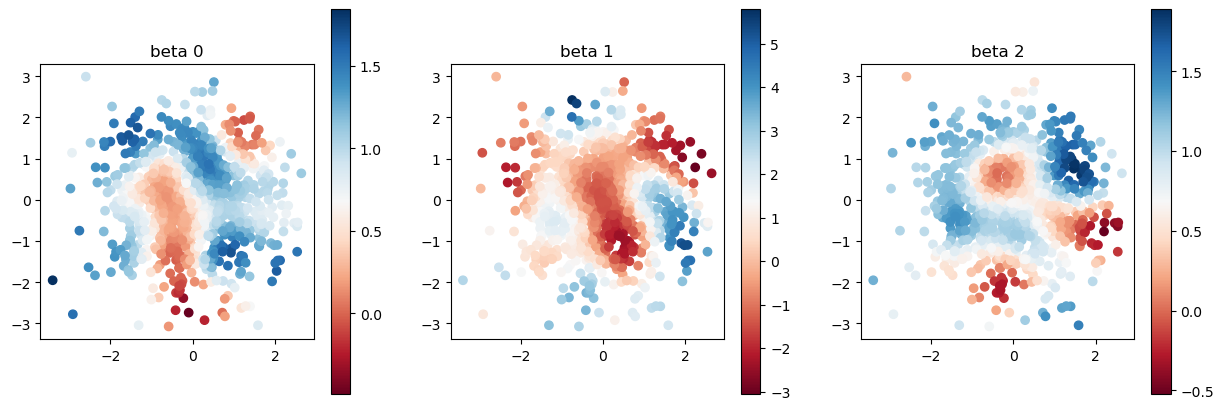

In [9]:
# This spatial coefficient model is inspired by Murakami et al. (2020)
def surface(sites, key, sigma, n_grid=30):
    s_min = jnp.min(sites, axis=0)
    s_max = jnp.max(sites, axis=0)

    x = jnp.linspace(s_min[0], s_max[0], num=n_grid)
    y = jnp.linspace(s_min[1], s_max[1], num=n_grid)
    x_ref, y_ref = np.meshgrid(x, y)
    x_ref = x_ref.flatten()
    y_ref = y_ref.flatten()
    ref = np.stack([x_ref, y_ref]).T

    d = np.linalg.norm(ref[:, None] - ref[None], axis=-1)
    G = jnp.exp(-d**2)

    beta_ref = random.multivariate_normal(key, mean=jnp.ones(len(ref)), cov=sigma**2*G, method="svd")

    interp = interpolate.RectBivariateSpline(x, y, beta_ref.reshape(n_grid, n_grid).T, s=0)
    beta = interp(sites[:,0], sites[:,1], grid=False)
    beta = jnp.array(beta)

    return beta

def DataGeneration(N, prngkey, sigma2=1.0):
    # sites
    key, prngkey = random.split(prngkey)
    sites = random.normal(key, shape=(N,2))

    # kernel
    G = jnp.linalg.norm(sites[:,None] - sites[None], axis=-1)
    G = jnp.exp(-jnp.square(G))

    # coefficients
    key, prngkey = random.split(prngkey)
    beta0 = surface(sites, key, sigma=0.5)
    # beta0 = random.multivariate_normal(key, mean=jnp.ones(N), cov=0.5**2 * G, method="svd")
    key, prngkey = random.split(prngkey)
    beta1 = surface(sites, key, sigma=2.0)
    # beta1 = random.multivariate_normal(key, mean=jnp.ones(N), cov=2.0**2 * G, method="svd")
    key, prngkey = random.split(prngkey)
    beta2 = surface(sites, key, sigma=0.5)
    # beta2 = random.multivariate_normal(key, mean=jnp.ones(N), cov=0.5**2 * G, method="svd")

    beta = jnp.stack([beta0, beta1, beta2]).T

    # X
    key, prngkey = random.split(prngkey)
    X = random.normal(key, shape=(N,2))
    X = jnp.concatenate([jnp.ones((N,1)), X], axis=1)

    # y
    y = beta0 + beta1 * X[:,1] + beta2 * X[:,2]
    key, prngkey = random.split(prngkey)
    y += sigma2**0.5 * random.normal(key, shape=(N,))

    return sites, y, X, beta

def plot_scatter(x, sites):
    fig = plt.figure(figsize=(15,5))
    for i in range(3):
        ax = fig.add_subplot(1,3,i+1)
        mappable = ax.scatter(sites[:,0], sites[:,1], c=x[:,i], cmap=plt.cm.RdBu)
        ax.set_title(f"beta {i}")
        ax.set_aspect("equal")
        fig.colorbar(mappable)
    # fig.show()

N = 1000
key = random.PRNGKey(123)
sites, y, X, beta = DataGeneration(N, key)
plot_scatter(beta, sites)

We show the scatter plot of the true coefficients of $\beta_0, \beta_1, \beta_2$.
We use the 1000 pairs of $(y_i, \bf{x}_i)$ to recover the coefficients. 
The relationship between $y$ and $\bf{x}$ is 

$$
y_i = \beta_{0i} + \beta_{1i} x_{i1} + \beta_{2i} x_{i2} + \varepsilon_i \\
{\bf{x}_i} = (1, x_{i0}, x_{i1})^\top
$$

The interesting point on this model is that the coefficients $\beta$ is not constant parameter and has spatial dependency.

## Reference

- 